# Определение возраста покупателей

## Исследовательский анализ данных

План проекта:

1. Провести исследовательский анализ набора фотографий
2. Подготовить данные к обучению
3. Обучить нейронную сеть и рассчитать её качество

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

Построим график распределения возраста

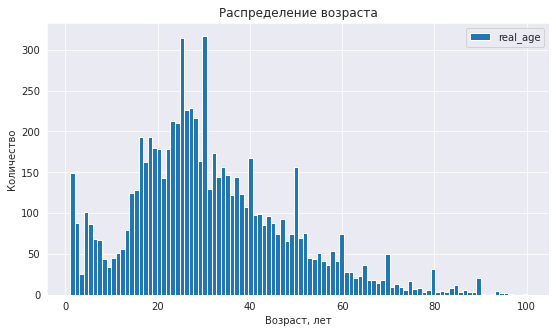

In [11]:
sns.set_style("dark")
labels.plot(kind='hist',figsize=(9,5),bins=100, grid=True)
plt.title('Распределение возраста')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')
plt.show()

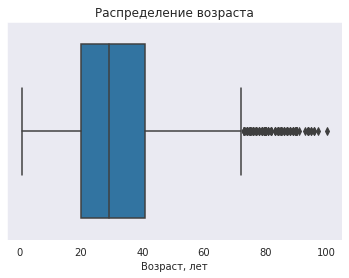

In [6]:
sns.boxplot(labels['real_age'])
plt.title('Распределение возраста')
plt.xlabel('Возраст, лет')
plt.show()

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


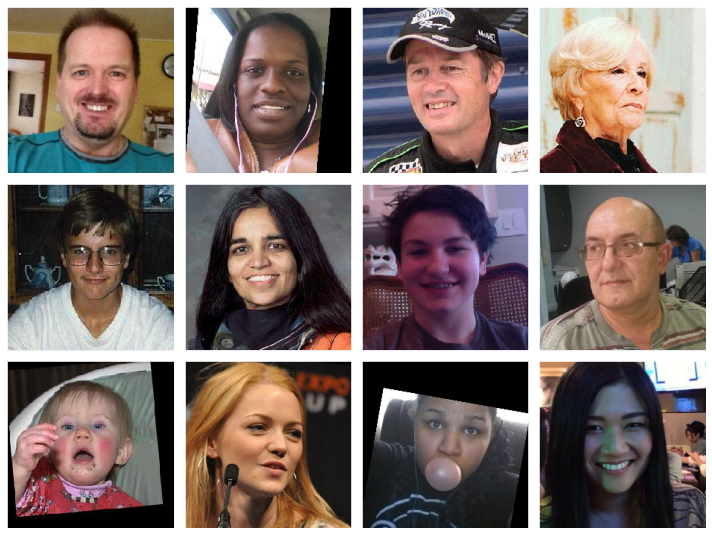

In [8]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


Вывод по п.1 В датасете 7591 фотография, 2 столбца, один из которых содержит фотографии, второй - возраст человека. Пропусков в таблице нет. Средний возраст - 31 год. Разброс от 1 года до 100 лет. Больше всего фотографий в диапазоне от 20 до 40 лет. Распределение по возрастам выглядит близко к нормальному, а все, что после 70 выглядит как выбросы. Но, нельзя исключить эту часть, т.к не сможем распознавать возрастных людей и в принципе логично, что чем больше возраст, тем ниже численность такой группы. В распределении наблюдается 2 пика. Возможно выборка детских фото собиралась и присоединялась отдельно. Пики на круглых числах возможно связаны с тем, что у некоторых изображений указывался примерный возраст, то есть округлялся до десятков. Фотографии выглядят относительно хорошо, без явных искажений в области лица, но освещение слабое. Фото сделаны с разных ракурсов, это может снизить качество обучения. На фотографиях присутствуют объекты, которые закрывают лицо: рука, жвачка, очки, головной убор и прочее, это также может повлиять на качество модели.

## Обучение модели

In [9]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
            weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
            include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 85s - loss: 10.4123 - mae: 10.4130 - val_loss: 24.6743 - val_mae: 24.6772
Epoch 2/10
356/356 - 66s - loss: 7.4830 - mae: 7.4829 - val_loss: 8.8872 - val_mae: 8.8850
Epoch 3/10
356/356 - 66s - loss: 6.5511 - mae: 6.5520 - val_loss: 6.9064 - val_mae: 6.9026
Epoch 4/10
356/356 - 64s - loss: 6.0138 - mae: 6.0142 - val_loss: 7.1013 - val_mae: 7.1040
Epoch 5/10
356/356 - 42s - loss: 5.4261 - mae: 5.4266 - val_loss: 6.5842 - val_mae: 6.5869
Epoch 6/10
356/356 - 43s - loss: 5.0127 - mae: 5.0127 - val_loss: 6.9905 - val_mae: 6.9877
Epoch 7/10
356/356 - 47s - loss: 4.6332 - mae: 4.6325 - val_loss: 6.4166 - val_mae: 6.4115
Epoch 8/10
356/356 - 46s - loss: 4.2720 - mae: 4.2719 - val_loss: 6.5678 - val_mae: 6.5773
Epoch 9/10
356/356 - 43s - loss: 3.9935 - mae: 3.9933 - val_loss: 7.1121 - val_mae: 7.1169
Epoch 10/10
356/356 - 42s - loss: 3.6816 - mae: 3.6816 - val_loss: 6.3859 - val_mae: 6.3875

119/119 - 10s - loss: 6.3859 - mae: 6.3875
Test MAE: 6.3875

## Анализ обученной модели

**Общий вывод**. Перед нами стояла задача построить и обучить модель, которая поможет определять возраст человека по изображению камеры со средним абсолютным отклонением MAE не выше 8.

В нашем распоряжении был датасет с 7591 размеченной фотографией, среди которых были фотографии выполненные при слабом освещении  и с присутствием объектов, которые закрывают лицо. Для того, чтобы модель обучилась точнее мы предварительно отделив % данных для тренировки модели, использовали специальные гиперпараметры, которые добавили в тренировочную выборку фотографии с похожими эффектами, а оставшиеся % оставили без изменений для тестирования модели.

В качестве основы за модель взяли уже предобученную нейросеть с архитектурой ResNet50 и дополнительно обучили её на наших данных без замораживания. В выходном слое для точного обучения модели, использовали оптимизацию Adam c шагом обучения 0.0001, функция активации - relu, а в качестве функции потерь использовалась mean_absolute_error (MAE).

С такими параметрами мы протестировали нашу модель на 10 эпохах и на 10-й эпохе обучения на тестовых данных, она достигла значения метрики MAE равное 6.3875. Таким образом мы достигли требуемой точности предсказания возраста. 